In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

# <center>Rossmann Store Sales</center>

This task is from Kaggle: https://www.kaggle.com/c/rossmann-store-sales

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

## <center>Data Preparation<center>

Let's see on our data:

- `Id` - an Id that represents a (Store, Date) duple within the test set
- `Store` - a unique Id for each store
- `Sales` - the turnover for any given day (TARGET)
- `Customers` - the number of customers on a given day
- `Open` - an indicator for whether the store was open: 
    - 0 = closed
    - 1 = open
- `StateHoliday` - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. 
  - a = public holiday
  - b = Easter holiday
  - c = Christmas
  - 0 = None
- `SchoolHoliday` - indicates if the (Store, Date) was affected by the closure of public schools
- `StoreType` - differentiates between 4 different store models: a, b, c, d
- `Assortment` - describes an assortment level: 
    - a = basic
    - b = extra
    - c = extended
- `CompetitionDistance` - distance in meters to the nearest competitor store
- `CompetitionOpenSince`[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- `Promo` - indicates whether a store is running a promo on that day
- `Promo2` - Promo2 is a continuing and consecutive promotion for some stores:
    - 0 = store is not participating
    - 1 = store is participating
- `Promo2Since`[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- `PromoInterval` - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_store = pd.read_csv("data/store.csv")

In [4]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [6]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Let's try with all features

In [23]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train['Year'] = df_train['Date'].map(lambda x: x.year)
df_train['Month'] = df_train['Date'].map(lambda x: x.month)
df_train['dayOfWeek'] = df_train['Date'].map(lambda x: x.dayofweek)
                                       
df_train.loc[df_train.StateHoliday == '0', 'StateHoliday'] = 0
holidays = pd.get_dummies(df_train['StateHoliday'], prefix='Hol')
df_train = pd.concat((df_train, holidays), axis=1)  
df_train = df_train.drop(['Date','StateHoliday','DayOfWeek'], axis=1)

df_train = df_train.set_index("Store")

In [24]:
df_store = pd.read_csv("data/store.csv")

df_store = df_store.set_index("Store")
store_type = pd.get_dummies(df_store['StoreType'], prefix='Type')
assort = pd.get_dummies(df_store['Assortment'], prefix='Assort')
df_store = pd.concat((df_store, store_type, assort), axis=1)  

df_store.CompetitionDistance = df_store.CompetitionDistance.fillna(df_store.CompetitionDistance.max())
df_store.Promo2SinceWeek = df_store.Promo2SinceWeek.fillna(df_store.Promo2SinceWeek.max())
df_store.Promo2SinceYear = df_store.Promo2SinceYear.fillna(df_store.Promo2SinceYear.max())
df_store.CompetitionOpenSinceMonth = df_store.CompetitionOpenSinceMonth.fillna(df_store.CompetitionOpenSinceMonth.max())
df_store.CompetitionOpenSinceYear = df_store.CompetitionOpenSinceYear.fillna(df_store.CompetitionOpenSinceYear.max())


df_store = df_store.drop(['Assortment','StoreType','PromoInterval'], axis=1)

In [25]:
df_train = df_train.join(df_store, on="Store")

In [26]:
X = train.drop(['Sales','Customers'],axis=1)
y = train.Sales.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y , test_size=0.7)

In [27]:
rf = RandomForestRegressor(n_jobs=-1, criterion='mse')
%time rf.fit(X_train, y_train)

CPU times: user 19.8 s, sys: 490 ms, total: 20.3 s
Wall time: 7.49 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
pd.DataFrame(rf.feature_importances_,X.columns)[0].sort_values(ascending=False)

CompetitionDistance    0.494021
Promo                  0.140802
Month                  0.089457
dayOfWeek              0.085142
Year                   0.033484
Type_b                 0.027332
Promo2                 0.026064
Type_d                 0.019552
Type_a                 0.019155
Type_c                 0.018884
SchoolHoliday          0.017743
Assort_c               0.016373
Assort_a               0.008447
Assort_b               0.001698
Hol_0                  0.001385
Hol_a                  0.000382
Hol_b                  0.000076
Hol_c                  0.000003
Open                   0.000000
Name: 0, dtype: float64

### Now let's not count some of them

In [4]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_store = pd.read_csv("data/store.csv")

In [5]:
df_store = df_store[["Store","StoreType", "Assortment", "CompetitionDistance","Promo2"]]
df_store = df_store.set_index("Store")
df_store.CompetitionDistance = df_store.CompetitionDistance.fillna(df_store.CompetitionDistance.max())
df_store.head()

,StoreType,Assortment,CompetitionDistance,Promo2
Store,,,,
1,c,a,1270.0,0
2,a,a,570.0,1
3,a,a,14130.0,1
4,c,c,620.0,0
5,a,a,29910.0,0


In [6]:
def data_preparation(df):
    df = df.join(df_store, on="Store")
    df.fillna(0, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].map(lambda x: x.year)
    df['Month'] = df['Date'].map(lambda x: x.month)
    df['dayOfWeek'] = df['Date'].map(lambda x: x.dayofweek)
    
    df.loc[df.StateHoliday == '0', 'StateHoliday'] = 0
    holidays = pd.get_dummies(df['StateHoliday'], prefix='Hol')
    store_type = pd.get_dummies(df['StoreType'], prefix='Type')
    assort = pd.get_dummies(df['Assortment'], prefix='Assort')
    df = pd.concat((df, holidays, store_type, assort), axis=1)  
    
    df = df.drop(['Store','Date','DayOfWeek','Assortment','StateHoliday','StoreType'], axis=1)
    return df

In [7]:
train = data_preparation(df_train)
train = train[train.Open == 1]
test = data_preparation(df_test)

## <center>Visualization<center>

In [52]:
full_store = pd.read_csv("data/store.csv")
full_train = pd.read_csv("data/train.csv")
full_df = full_train.join(df_store, on="Store")
full_df.loc[full_df.StateHoliday == '0', 'StateHoliday'] = 0

In [59]:
full_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
63555,1,4,2015-06-04,0,0,0,1,a,0,c,a,1270.0,0
63557,3,4,2015-06-04,0,0,0,1,a,0,a,a,14130.0,1
63559,5,4,2015-06-04,5807,625,1,1,a,0,a,a,29910.0,0
63560,6,4,2015-06-04,5749,614,1,1,a,0,a,a,310.0,0
63563,9,4,2015-06-04,0,0,0,1,a,0,a,c,2030.0,0


The average sales per day of week:

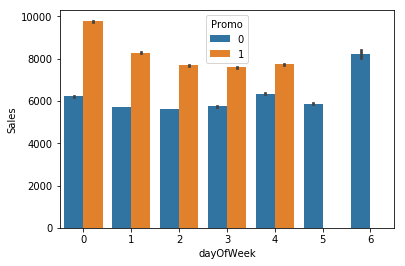

In [44]:
avg = train[['Sales', 'Customers', 'Promo']].groupby(['Promo']).mean()
sns.barplot(x="dayOfWeek", y="Sales", hue="Promo", order=[0, 1, 2, 3, 4, 5, 6], data=train);

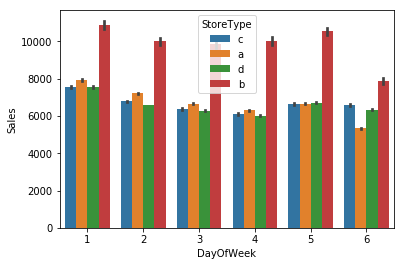

In [46]:
avg = full_df[['Sales', 'Customers', 'StoreType']].groupby(['StoreType']).mean()
sns.barplot(x="DayOfWeek", y="Sales", hue="StoreType", order=[1, 2, 3, 4, 5, 6], data=full_df);

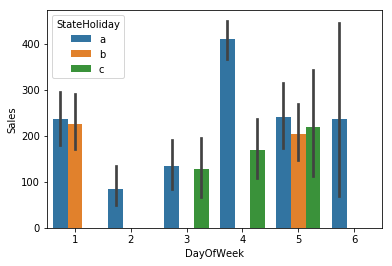

In [57]:
full_df = full_df[full_df['StateHoliday'] != 0]
avg = full_df[['Sales', 'Customers', 'StateHoliday']].groupby(['StateHoliday']).mean()
sns.barplot(x="DayOfWeek", y="Sales", hue="StateHoliday", order=[1, 2, 3, 4, 5, 6], data=full_df);

#### The average per month

In [60]:
full_df['Date'] = pd.to_datetime(full_df['Date'])
full_df['Month'] = full_df['Date'].map(lambda x: x.month)

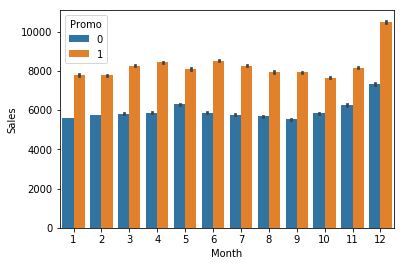

In [48]:
avg = train[['Sales', 'Customers', 'Promo']].groupby(['Promo']).mean()
sns.barplot(x="Month", y="Sales", hue="Promo", order=[1, 2, 3, 4, 5, 6,7,8,9,10,11,12], data=train);

#### Notice that I exclude None values

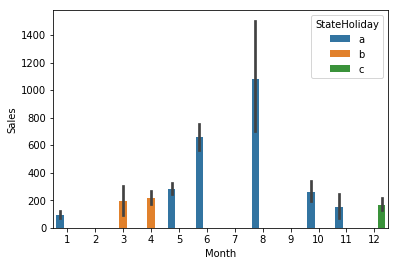

In [61]:
avg = full_df[['Sales', 'Customers', 'StateHoliday']].groupby(['StateHoliday']).mean()
sns.barplot(x="Month", y="Sales", hue="StateHoliday", order=[1, 2, 3, 4, 5, 6,7,8,9,10,11,12], data=full_df);

## <center>Train the model<center>

We noticed that in test dataset there are no any StateHolidays of type 'b' anc 'c'

In [8]:
X = train.drop(['Sales','Customers','Hol_b','Hol_c'],axis=1)
y = train.Sales.values

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y , test_size=0.7)

In [10]:
rf = RandomForestRegressor(n_jobs=-1, criterion='mse')
%time rf.fit(X_train, y_train)

CPU times: user 24.3 s, sys: 327 ms, total: 24.6 s
Wall time: 9.04 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [11]:
pred = rf.predict(X_valid)
rmspe(pred, y_valid)

0.30131395101667824

### <center>Write to csv file<center>

In [12]:
model = RandomForestRegressor(min_samples_leaf=2, max_depth=30, n_estimators=30)
%time model.fit(X, y)

CPU times: user 1min 44s, sys: 575 ms, total: 1min 45s
Wall time: 1min 45s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [13]:
pd.DataFrame(rf.feature_importances_,X.columns)[0].sort_values(ascending=False)

CompetitionDistance    0.497852
Promo                  0.140357
Month                  0.089561
dayOfWeek              0.085243
Year                   0.032832
Type_b                 0.027140
Promo2                 0.025527
Type_d                 0.020493
Type_c                 0.018980
Type_a                 0.018958
SchoolHoliday          0.017577
Assort_c               0.013643
Assort_a               0.009224
Hol_0                  0.001187
Assort_b               0.001021
Hol_a                  0.000404
Open                   0.000000
Name: 0, dtype: float64

In [15]:
y = model.predict(test.values[:, 1:])

df = pd.DataFrame([])
df['Sales'] = y
df['Sales'][df_test.Open == 0] = 0
df = df.set_index(df_test.Id)
pd.DataFrame.to_csv(df, 'ans1.csv')
df.head()

,Sales
Id,
1,7146.124650
2,7840.264881
3,10084.786111
4,8365.955556
5,8185.560047


The result is shown on picture below

It seems that the results are improving
![title](kaggle.png)

What could we do to make our model better?  